In [64]:
import pandas as pd
import numpy as np

## Limpieza

In [65]:
indiv_2004 = pd.read_stata('./input/Individual_t104.dta', convert_categoricals= False) # Leo la base individual para 2004, no quiero que me guarde el formato de stata, así que no convierto las variables categóricas
#indiv_2024 = pd.read_excel('./input/usu_individual_T124.xlsx') # Leo la base individual para 2024, acá no tengo problemas con el formato
hog_2004 = pd.read_stata('./input/Hogar_t104.dta', convert_categoricals= False) # Leo la base de hogares para 2004, devuelta cambio el formato
#hog_2024 = pd.read_excel('./input/usu_hogar_T124.xlsx') # Leo la base de hogares para 2024

# Los excel tardan bastante en cargar, así que vamos a guardarlos en otro formato

In [66]:
#indiv_2024.to_csv('./input//usu_individual_T124.csv', index= False)
#hog_2024.to_csv('./input/usu_hogar_T124.csv', index = False)

In [67]:
tipos_indiv = indiv_2004.dtypes.to_dict() # Vemos los dtypes de la base de 2004
# Lo guardamos como diccionario para cuando cargue el csv poder especificarle al read_csv los dtypes de la base de 2024
# Cambiamos los dtypes de las columnas que nos van a a interesar
tipos_indiv['ch04'] = 'category'
tipos_indiv['estado'] = 'category'
tipos_indiv['cat_inac'] = 'category'
tipos_indiv['nivel_ed'] = 'category'
tipos_indiv['ch07'] = 'category'
tipos_indiv['ch08'] = 'category'
tipos_indiv['ano4'] = 'category'
tipos_indiv['aglomerado'] = 'category'
tipos_indiv['trimestre'] = 'category'
tipos_indiv['nro_hogar'] = 'category'

# Las asignamos al df
indiv_2004 = indiv_2004.astype(tipos_indiv)

In [68]:
# También guardo lod dtypes de la base de hogares para cargar bien el csv
tipos_hog = hog_2004.dtypes.to_dict()
tipos_hog['iv3'] = 'category'
tipos_hog['iv4'] = 'category'
tipos_hog['iv5'] = 'category'
tipos_hog['iv6'] = 'category'
tipos_hog['iv7'] = 'category'
tipos_hog['iv9'] = 'category'
tipos_hog['iv10'] = 'category'
tipos_hog['iv11'] = 'category'
tipos_hog['ii7'] = 'category'
tipos_hog['ii8'] = 'category'
tipos_hog['ii9'] = 'category'
tipos_hog['v1'] = 'category'
tipos_hog['v2'] = 'category'
tipos_hog['v21'] = 'category'
tipos_hog['v22'] = 'category'
tipos_hog['v3'] = 'category'
tipos_hog['v4'] = 'category'
tipos_hog['v5'] = 'category'
tipos_hog['v6'] = 'category'
tipos_hog['v7'] = 'category'
tipos_hog['v8'] = 'category'
tipos_hog['v9'] = 'category'
tipos_hog['v10'] = 'category'
tipos_hog['v11'] = 'category'
tipos_hog['v13'] = 'category'
tipos_hog['v14'] = 'category'
tipos_hog['v15'] = 'category'
tipos_hog['v16'] = 'category'
tipos_hog['v17'] = 'category'
tipos_hog['v18'] = 'category'
tipos_hog['v19_a'] = 'category'
tipos_hog['v19_b'] = 'category'

hog_2004 = hog_2004.astype(tipos_hog)

In [69]:
# Cargo los csv que guarde antes con el dtype correcto y más rápido que un excel
indiv_2024 = pd.read_csv('./input/usu_individual_T124.csv', dtype = tipos_indiv, low_memory= False)
hog_2024 = pd.read_csv('./input/usu_hogar_T124.csv', dtype = tipos_hog, low_memory= False)

In [70]:
cols_ind = indiv_2004.columns # columnas en la base individual
cols_hog = hog_2004.columns # columnas en la base de hogares

cols_comunes = [col for col in cols_hog if col in cols_ind] # guardo las columnas que tienen en común
data_2004 = pd.merge(indiv_2004, hog_2004, on= cols_comunes[:7], how='inner', suffixes=('_indiv', '_hog')) # hago el merge en base a las columnas que tienen en común
# Antes me duplicaba las columnas en el merge

In [71]:
# Las bases de 2024 tienen las variables en mayúscula, lo que después puede ser un problema
indiv_2024.columns = indiv_2024.columns.str.lower() # las paso a minúscula
hog_2024.columns = hog_2024.columns.str.lower()

# De vuelta agarro las columnas en común y hago el merge en base a esas
cols_ind = indiv_2024.columns
cols_hog = hog_2024.columns

cols_comunes = [col for col in cols_hog if col in cols_ind]
data_2024 = pd.merge(indiv_2024, hog_2024, on = cols_comunes[:7], how='inner', suffixes= ('_indiv', '_hog'))

# La unica variable que quiero que tenga nombre en mayúscula es CODUSU
data_2024.rename(columns={'codusu': 'CODUSU'}, inplace=True)

In [72]:
# Juntamos ambas bases en una única base
data = pd.concat([data_2004, data_2024], ignore_index= True)

In [73]:
# Agarro los dtypes correctos y se los aplico a la base entera
categorical_columns = indiv_2004.select_dtypes(include= 'category').columns
# Para compatibilizar ambas bases hacemos lo mismo que para la de 2004
for col in categorical_columns:
    data[col] = data[col].astype(int) # Las paso a integer

for col in categorical_columns:
    data[col] = data[col].astype('category') # Devuelta las paso a categoría

# Hago lo mismo para los dtypes de la de hogares
categorical_columns = hog_2004.select_dtypes(include = 'category')
for col in categorical_columns:
    data[col] = data[col].astype(int) # Las paso a integer

for col in categorical_columns:
    data[col] = data[col].astype('category') # Devuelta las paso a categoría


In [74]:
data = data.loc[data['aglomerado'] == 4] # Nos quedamos únicamente con las observaciones de Bahía Blanca

# Limpiamos la base. Nos quedamos con las observaciones que tienen un ingreso mayor o igual a 0, las edades mayores o iguales a 0
data = data.loc[(data['ipcf_indiv']>=0) & (data['ch06']>=0)]

In [ ]:
# Primera variable que armamos: cantidad de personas inactivas en el hogar
# Generamos una dummy de inactivo
data['inactiva'] = (data['estado'] == 3).astype(int)
# Agupamos por codusu y nro_hogar y contamos cuantas personas inactivas hay en el hogar
data['cantidad_inactivos'] = data.groupby(['CODUSU', 'nro_hogar'])['inactiva'].transform('sum')

In [ ]:
# Segunda variable: hacinamiento
# Contamos la cantidad de miembros por hogar
data['miembros_hogar'] = data.groupby(['CODUSU', 'nro_hogar'])['componente'].transform('count')

# Vemos si hay más de tres personas por ambiente
data['hacinamiento'] = (data['miembros_hogar'] / data['iv2'] > 3).astype(int)

In [ ]:
# Tercera variable: Ingreso no laboral per cápita
# El valor t_vi = -9 es NA, entonces puede quedarnos un t_vi negativo
data['ingreso_no_laboral_pc'] = data['t_vi'] / data['miembros_hogar']

# Filtramos el ingreso no laboral per cápita que sea mayor o igual a 0
data = data.loc[data['ingreso_no_laboral_pc']>=0]

In [78]:
# Guardo el df en formato pickle para que me guarde los dtypes
data.to_pickle('./input/data.pkl')

In [79]:
# Cargo la base
data = pd.read_pickle('./input/data.pkl')

In [80]:
respondieron = data.loc[data['estado'] != 0] # creamos base con personas que respondieron su condición de actividad
norespondieron = data.loc[data['estado'] == 0] # creamos base con personas que no respondieron su condición de actividad

In [81]:
desocupada = pd.DataFrame(
    np.where(respondieron['estado'].isin([2]), 1, 0),  # Creo la columna "desocupada"
    columns=['desocupada'],
    index=respondieron.index  # Le pongo el index del df respondieron para que haga bien el concat
)
respondieron = pd.concat([respondieron, desocupada], axis=1) # Le agrego la columna al df

## Clasificación

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from typing import Literal
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
# Definimos las columnas de interés
columnas = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'ipcf_indiv', 'ipcf_hog', 'ingreso_no_laboral_pc', 'hacinamiento', 'cantidad_inactivos', 'v1', 'v2', 'v21', 'v22', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v13', 'v14', 'v15', 'v17', 'v18', 'v19_a', 'v19_b']
# Definimos para cada año variable explicada
y_2004 = respondieron.loc[respondieron['ano4']==2004]['desocupada'] 
y_2024 = respondieron.loc[respondieron['ano4']==2024]['desocupada']

# Definimos para cada año vector de variables explicativas (en formato dummy) 
x_2004 = pd.get_dummies(respondieron.loc[respondieron['ano4']==2004][columnas])
x_2024 = pd.get_dummies(respondieron.loc[respondieron['ano4']==2024][columnas])

# Agregamos constantes
x_2004['constante'] = 1
x_2024.loc[:,'constante'] = 1

# Asignamos el 30% de cada base a testeo y por ende el 70% a entrenamiento 
x_train_2004, x_test_2004, y_train_2004, y_test_2004 = train_test_split(x_2004, y_2004, test_size = 0.3, random_state = 101)
x_train_2024, x_test_2024, y_train_2024, y_test_2024 = train_test_split(x_2024, y_2024, test_size = 0.3, random_state = 101)

Para regularización hace falta estandarizar primero las variables, para que no pondere más por una cuestión de varianza

In [84]:
# Estandarizamos las variables
sc = StandardScaler()
x_train_2004 = pd.DataFrame(sc.fit_transform(x_train_2004), index= x_train_2004, columns= x_train_2004.columns)
x_train_2024 = pd.DataFrame(sc.fit_transform(x_train_2024), index= x_train_2024, columns= x_train_2024.columns)
x_test_2004 = pd.DataFrame(sc.fit_transform(x_test_2004), index= x_test_2004, columns= x_test_2004.columns)
x_test_2024 = pd.DataFrame(sc.fit_transform(x_test_2024), index= x_test_2024, columns= x_test_2024.columns)

In [85]:
# Armo una función que estima un modelo logit con distintas penalidades y devuelve las métricas para evaluarlo
def logit_penalty_eval(x_train, x_test, y_train, y_test, penalty: Literal['l1', 'l2']):
    if penalty == 'l1':
        solver = 'liblinear' # La penalidad l1 no funciona con el solver por default de logit
    else:
        solver = 'lbfgs'
    
    logit = LogisticRegression(penalty= penalty, solver=solver) 
    logit.fit(x_train, y_train) # Estimamos el modelo
    y_pred = logit.predict(x_test) # Predecimos fuera de la muestra
    y_prob = logit.predict_proba(x_test)[:, 1]
    
    # Evaluamos
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred)
    
    return cm, auc, accuracy

In [86]:
# Para 2004
for p in ['l1', 'l2']:
    cm, auc, accuracy = logit_penalty_eval(x_train_2004, x_test_2004, y_train_2004, y_test_2004, p)
    print(cm)
    print(auc)
    print(accuracy)

[[673   3]
 [ 53   1]]
0.7973098838483453
0.9232876712328767
[[672   4]
 [ 53   1]]
0.7953374972605741
0.9219178082191781


In [87]:
# Para 2024
for p in ['l1', 'l2']:
    cm, auc, accuracy = logit_penalty_eval(x_train_2024, x_test_2024, y_train_2024, y_test_2024, p)
    print(cm)
    print(auc)
    print(accuracy)

[[473   1]
 [  9   0]]
0.6964369432723863
0.979296066252588
[[473   1]
 [  9   0]]
0.6872948898265354
0.979296066252588


In [88]:
alphas = [10**i for i in range(-5, 5, 1)] # Armamos la grilla de valores posibles para lambda

In [89]:
# Armo una función que hace 10-fold cv y encuentra el mejor alpha para ridge
# Después me guarda los valores para el MSE para cada par alpha-fold

def ridge_eval(alphas, x_train, y_train):
    ridgecv = RidgeCV(alphas= alphas, cv =10).fit(x_train, y_train) # 10-fold CV
    alpha = ridgecv.alpha_ # El mejor alpha
    
    mses = pd.DataFrame()
    for alpha in alphas: # Itero para cada alpha en mi grilla
        ridge = Ridge(alpha=alpha) # Hago Ridge con ese alpha
        mses[f'{alpha}'] = -cross_val_score(ridge, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
		# Me guardo el MSE para cada fold
    mses = mses.melt() # Guardo todo en un df
    return alpha, mses

In [90]:
# Función para el boxplot
def box(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='variable', y='value', data=data)
    plt.title("Distribución de errores por valor de alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Error cuadrático medio")
    plt.show()

El mejor alpha para Ridge en 2004 es: 10000


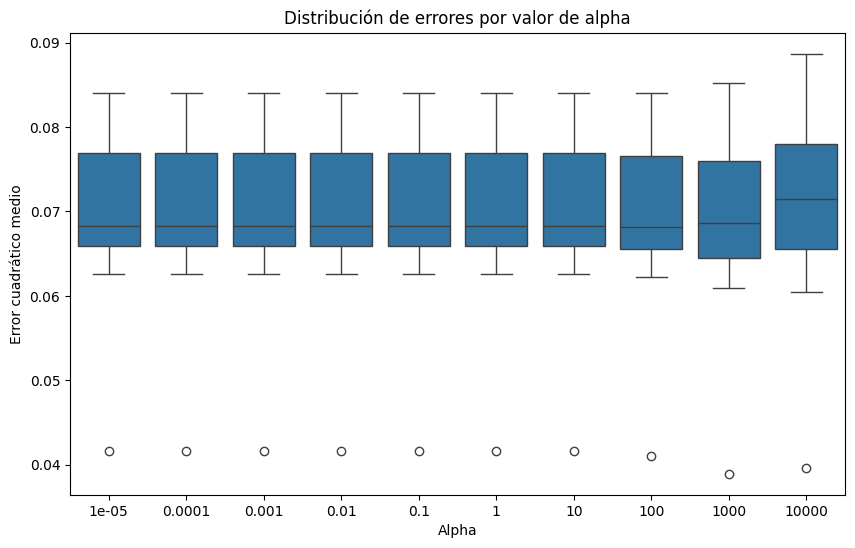

In [ ]:
# Aplico la función para 2004 y grafico el boxplot
alpha, mses = ridge_eval(alphas, x_train_2004, y_train_2004)
print(f"El mejor alpha para Ridge en 2004 es: {alpha}")
box(mses)

El mejor alpha para Ridge en 2024 es: 10000


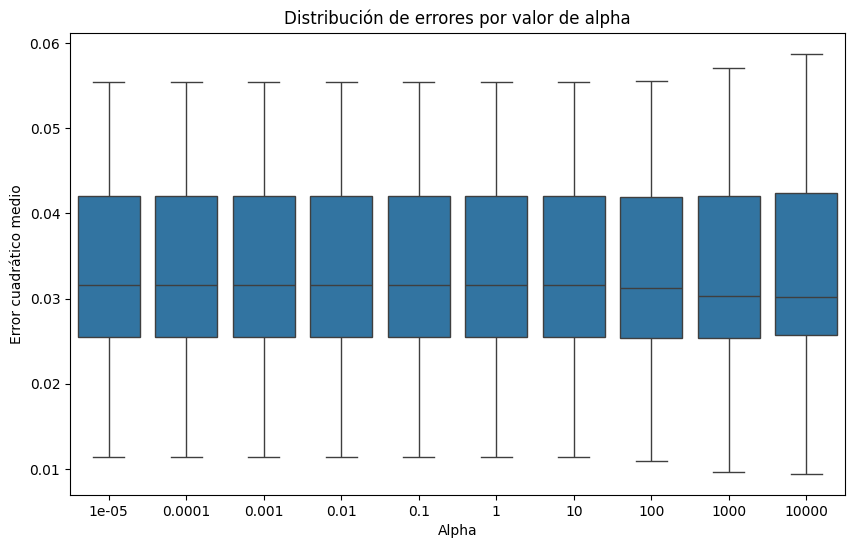

In [ ]:
# Ahora para 2024
alpha, mses = ridge_eval(alphas, x_train_2024, y_train_2024)
print(f"El mejor alpha para Ridge en 2024 es: {alpha}")
box(mses)

In [93]:
# Función para el lineplot
def line_prop(prop):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=prop, x='alpha', y='zero_coef_ratio', marker='o', color='b')
    plt.xscale('log')
    plt.xlabel(r'$\alpha$ (log)', fontsize=12)
    plt.ylabel('Proporción de Coeficientes = 0', fontsize=12)
    plt.title('Proporción de Coeficientes Nulos', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [94]:
# Esta función hace lo mismo que la de ridge, pero con LASSO
def lasso_eval(alphas, x_train, y_train):
    lassocv = LassoCV(alphas= alphas, cv =10).fit(x_train, y_train) # 10-fold CV
    
    alpha = lassocv.alpha_ # El mejor alpha
    mses = pd.DataFrame(lassocv.mse_path_, columns= alphas).melt() # Me guardo el MSE para cada fold
    
    zero_coef_proportion = [] # Además piden la proporción de coeficientes nulos
    for alpha_val in alphas: # Itero para cada alpha en mi grilla
        lasso = Lasso(alpha=alpha_val, max_iter=10000).fit(x_train, y_train) # Hago LASSO con ese alpha
        coef_zero_ratio = np.mean(lasso.coef_ == 0) # Saco el promedio de coeficientes nulos (en este caso también es la proporción)
        zero_coef_proportion.append({'alpha': alpha_val, 'zero_coef_ratio': coef_zero_ratio}) # Lo guardo en una lista
    
    zero_coef_df = pd.DataFrame(zero_coef_proportion)  # Convierto la lista a df
    
    return alpha, mses, zero_coef_df

El mejor alpha para Ridge en 2004 es: 0.01


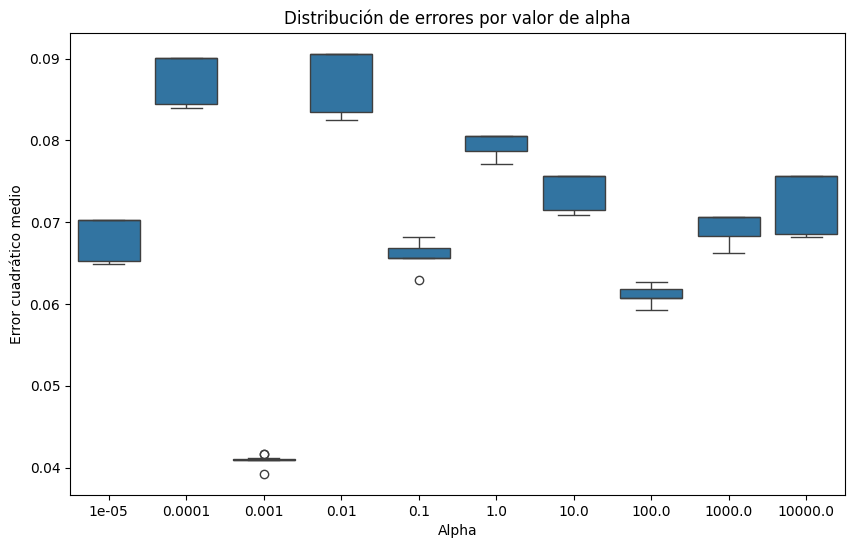

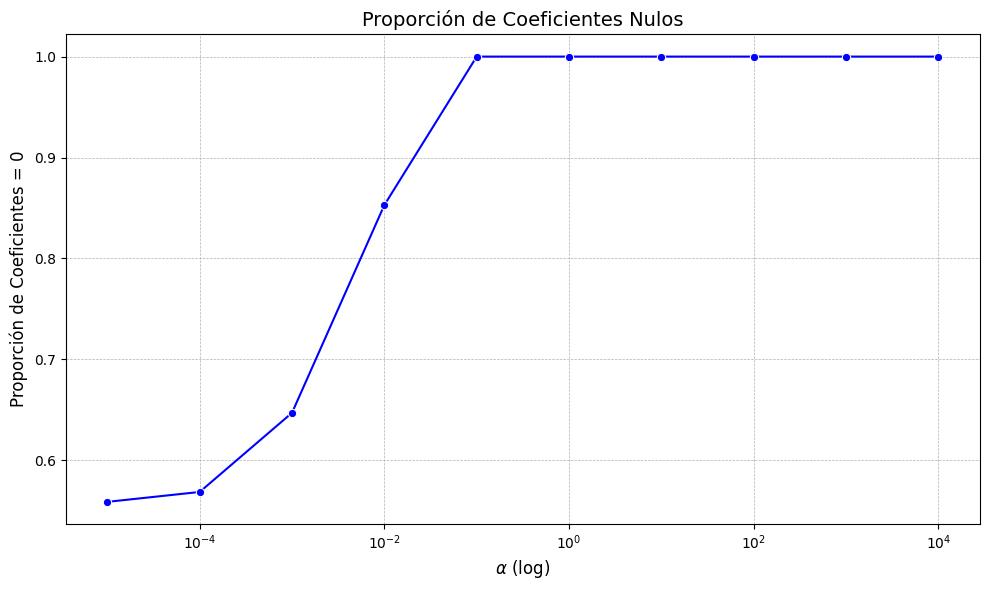

In [ ]:
# Aplico LASSO a 2004
alpha, mses, prop = lasso_eval(alphas, x_train_2004, y_train_2004)
print(f"El mejor alpha para Ridge en 2004 es: {alpha}")
box(mses)
line_prop(prop)

El mejor alpha para Ridge en 2024 es: 0.01


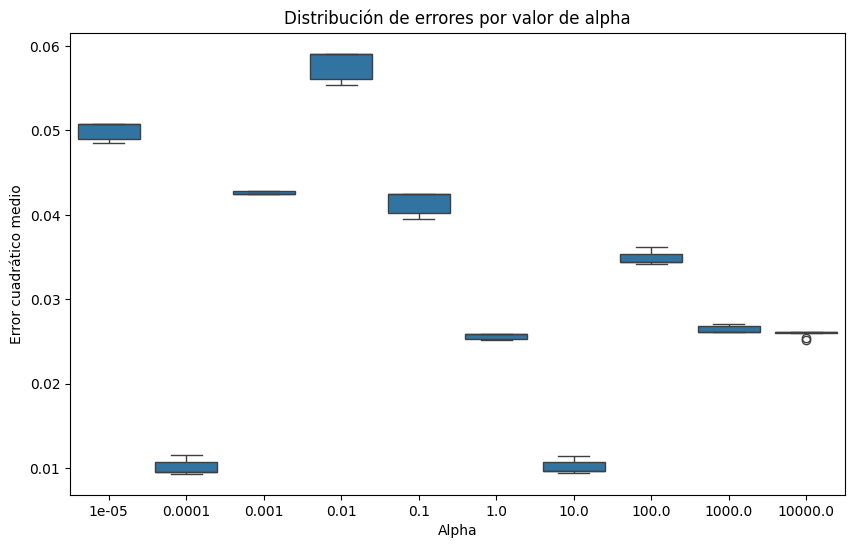

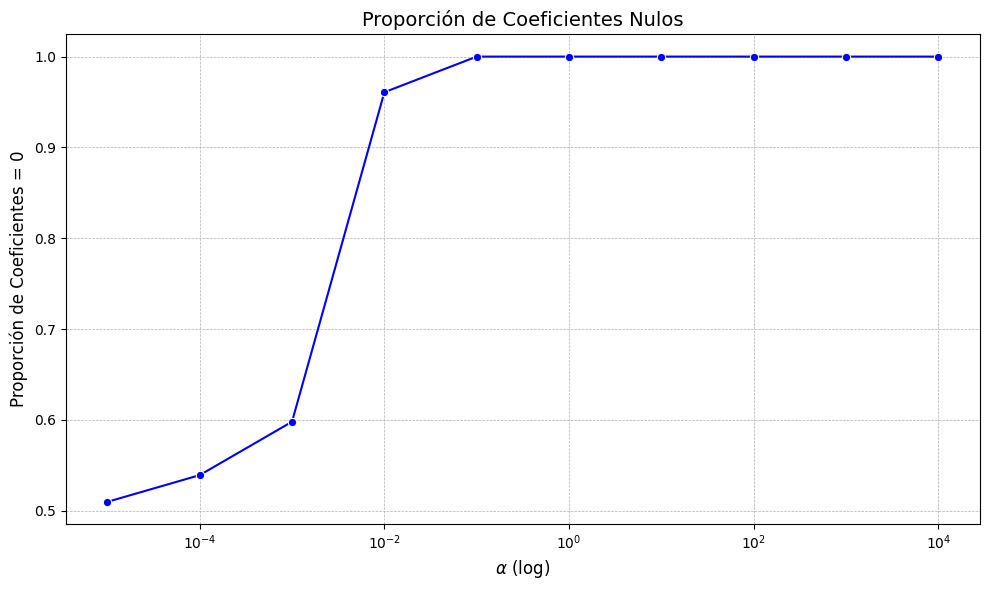

In [ ]:
# Ahora a 2024
alpha, mses, prop = lasso_eval(alphas, x_train_2024, y_train_2024)
print(f"El mejor alpha para Ridge en 2024 es: {alpha}")
box(mses)
line_prop(prop)